## <font color='darkblue'>Preface</font>
([source](https://www.analyticsvidhya.com/blog/2021/11/a-guide-to-building-an-end-to-end-multiclass-text-classification-model/#)) Natural language processing (NLP) is everywhere, one of the most used concepts in the business world. Whether to predict the sentiment in a sentence or to differentiate the emails, flag a toxic comment, all these scenarios use a strong natural language processing concept called text classification. I can understand in the above cases we have a maximum target class or two or three. Can we go beyond that? <b>Can we build a multi-Class</b> (<font color='brown'>say more than 5</font>) <b>text classification model? Well! Yes, we can do it.</b>

<b><font size='3ptx'>Today we will implement a multi-class text classification model on an open-source dataset and explore more about the steps and procedure. Let’s begin.</font></b>

### <font color='darkgreen'>Table of Contents</font>
1. <font size='3ptx'><b><a href='#sect1'>Dataset</a></b></font>
2. <font size='3ptx'><b><a href='#sect2'>Text processing</a></b></font>
3. <font size='3ptx'><b><a href='#sect3'>Exploring Multi-classification Models</a></b></font>
4. <font size='3ptx'><b><a href='#sect4'>Compare Text Classification Model performance</a></b></font>
5. <font size='3ptx'><b><a href='#sect5'>Evaluation of Text Classification Model</a></b></font>
6. <font size='3ptx'><b><a href='#sect6'>Prediction</a></b></font>

<a id='sect1'></a>
## <font color='darkblue'>Dataset for Text Classification</font>
The dataset which we are going to use is available publicly, and it is quite a huge dataset. It consists of complaints received from the consumer regarding the products and services. The dataset is available here (https://catalog.data.gov/dataset/consumer-complaint-database or <a href='https://www.kaggle.com/selener/consumer-complaint-database'>Kaggle link</a>).

The dataset consists of real-world complaints received from the customers regarding financial products and services. The complaints are labeled to a specific product. Hence, we can conclude that this is a supervised problem statement, where we have the input and the target output for that. We will play with different machine learning algorithms and check which algorithm works better.

<font size='3ptx'><b>Our aim is to classify the complaints of the consumer into predefined categories using a suitable classification algorithm</b></font>. For now, we will be using the following classification algorithms:
* Linear Support Vector Machine (LinearSVM)
* Random Forest
* Multinomial Naive Bayes
* Logistic Regression.

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

### <font color='darkgreen'>Loading the Data</font>
Download the dataset from the link given in the above section and store it to your local drive (<font color='brown'>Here I stored it under path</font> <font color='olive'>../../datas/kaggle_consumer-complaint-database/rows.csv</font>)

In [4]:
# loading data
df = pd.read_csv('../../datas/kaggle_consumer-complaint-database/rows.csv')
print(df.shape)
df.sample(n=3)

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(1282355, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
1281123,12/12/2011,Credit card,NaN,Billing disputes,NaN,NaN,NaN,U.S. BANCORP,MO,63139,Older American,NaN,Web,12/13/2011,Closed without relief,Yes,No,4756
343347,12/31/2017,Debt collection,Medical debt,Attempts to collect debt not owed,Debt was paid,NaN,Company believes it acted appropriately as aut...,"Retrieval-Masters Creditors Bureau, Inc.",TX,75041,NaN,Consent not provided,Web,12/31/2017,Closed with explanation,Yes,NaN,2768328
1277103,01/26/2012,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,WELLS FARGO & COMPANY,CA,95472,NaN,NaN,Referral,01/30/2012,Closed without relief,Yes,No,18344


From the output of the above code, we can say that the dataset is very huge and it has 18 columns and total 1,282,355 rows.

Now, for our multi-class text classification task, <b>we will be using only two of these columns out of 18, that is the column with the name `Product` and the column `Consumer complaint narrative`.</b> Now let us create a new DataFrame to store only these two columns and since we have enough rows, we will remove all the missing (NaN) values. To make it easier to understand we will rename the second column of the new DataFrame as `consumer_complaints`.

In [5]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

In [6]:
# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

In [7]:
# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

In [8]:
print(df1.shape)
df1.sample(3).T

(383564, 2)


,899300,828219,437468
Product,Credit reporting,Debt collection,Credit card or prepaid card
Consumer_complaint,"I filed bankruptcy on XXXX XXXX, and my mortga...",I contacted an original creditor ( XXXX XXXX )...,On XX/XX/XXXX two fraudulent charges were made...


We can see that after discarding all the missing values, we have around 383k rows and 2 columns, this will be our data for training. Now let us <b>check how many unique products are there</b>.

In [9]:
pd.DataFrame(df1.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Debt collection'],
       ['Student loan'],
       ['Mortgage'],
       ['Credit card or prepaid card'],
       ['Checking or savings account'],
       ['Money transfer, virtual currency, or money service'],
       ['Vehicle loan or lease'],
       ['Payday loan, title loan, or personal loan'],
       ['Credit card'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

There are 18 categories in products. To make the training process easier, we will do some changes in the names of the category.

In [10]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [11]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Debt collection
2,Consumer Loan
3,Credit card or prepaid card
4,Mortgage
5,Vehicle loan or lease
6,Student loan
7,"Payday loan, title loan, or personal loan"
8,Checking or savings account
9,Bank account or service


The 18 categories are now reduced to 13, we have combined `Credit Card` and `Prepaid card` to a single class and so on.

Now, we will <b>map each of these categories to a number, so that our model can understand it in a better way and we will save this in a new column named `category_id`</b>. Where each of the 13 categories is represented in numerical.

In [12]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()

In [14]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
category_to_id

{'Credit reporting, repair, or other': 0,
 'Debt collection': 1,
 'Consumer Loan': 2,
 'Credit card or prepaid card': 3,
 'Mortgage': 4,
 'Vehicle loan or lease': 5,
 'Student loan': 6,
 'Payday loan, title loan, or personal loan': 7,
 'Checking or savings account': 8,
 'Bank account or service': 9,
 'Money transfer, virtual currency, or money service': 10,
 'Money transfers': 11,
 'Other financial service': 12}

In [15]:
# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
310399,"Credit reporting, repair, or other",Bayview completely ignored laws and is reporti...,0
186155,"Credit reporting, repair, or other",inaccurate information no knowledge of account...,0
651135,Debt collection,On XXXX/XXXX/2016 I received a notice from Con...,1
515233,Consumer Loan,I have a loan with Kia Motor Finance. I rece...,2
641112,Credit card or prepaid card,I have a XXXX BIG card and made my payment whe...,3


Let us visualize the data, and see how many numbers of complaints are there per category. We will use Bar chart here.

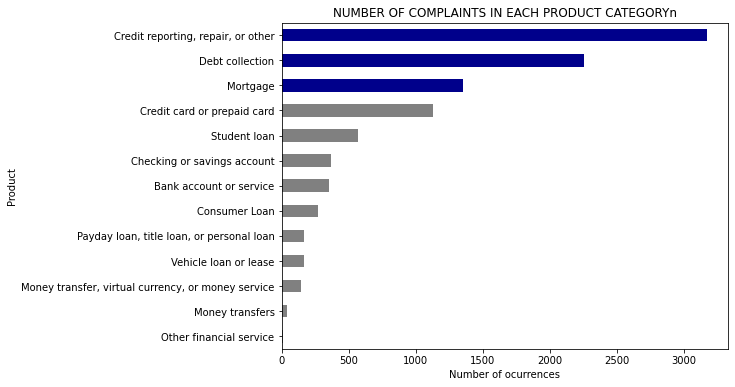

In [16]:
fig = plt.figure(figsize=(8,6))
colors = [
    'grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORYn')
plt.xlabel('Number of ocurrences', fontsize = 10);

Above graph shows that most of the customers complained regarding:
* Credit reporting, repair, or other
* Debt collection
* Mortgage

<a id='sect2'></a>
## <font color='darkblue'>Text processing</font>
<font size='3ptx'><b>The text needs to be preprocessed so that we can feed it to the classification algorithm. Here we will transform the texts into vectors using Term Frequency-Inverse Document Frequency</b> (TFIDF) <b>and evaluate how important a particular word is in the collection of words</b></font>. For this we need to remove punctuations and do lower casing, then the word importance is determined in terms of frequency.

We will be using <b><a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html'>TfidfVectorizer</a></b> function with the below parameters:
* **min_df**: remove the words which has occurred in less than ‘min_df’ number of files.
* **Sublinear_tf**: if True, then scale the frequency in logarithmic scale.
* **Stop_words**: it removes stop words which are predefined in ‘english’.

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()
labels = df2.category_id
print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" % (features.shape))

Each of the 10000 complaints is represented by 27507 features (TF-IDF score of unigrams and bigrams)


In [21]:
features[0].shape

(27507,)

Now, we will <b>find the most correlated terms with each of the defined product categories</b>. Here we are finding only three most correlated terms.

In [18]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

n==> Bank account or service:
  * Most Correlated Unigrams are: overdraft, bank, scottrade
  * Most Correlated Bigrams are: citigold checking, debit card, checking account
n==> Checking or savings account:
  * Most Correlated Unigrams are: checking, branch, overdraft
  * Most Correlated Bigrams are: 00 bonus, overdraft fees, checking account
n==> Consumer Loan:
  * Most Correlated Unigrams are: dealership, vehicle, car
  * Most Correlated Bigrams are: car loan, vehicle loan, regional acceptance
n==> Credit card or prepaid card:
  * Most Correlated Unigrams are: express, citi, card
  * Most Correlated Bigrams are: balance transfer, american express, credit card
n==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: report, experian, equifax
  * Most Correlated Bigrams are: credit file, equifax xxxx, credit report
n==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collector, collect debt, collection 

For each category it will show the three most correlated terms. We can find any number of correlated terms per category, in the above code the value of `N` is set to 3, which means it will <b>display the 3 most correlated terms, feel free to change the number and check all the terms are highly correlated</b>. But for this small task, in order to know which terms have more weightage, we will just see the top three correlated terms.

<a id='sect3'></a>
## <font color='darkblue'>Exploring Multi-classification Models</font>
The classification models which we are using:
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes
* Logistic Regression.
<br/>

For more information regarding each model, you can refer to their <a href='https://scikit-learn.org/stable/index.html'>official guide</a>.

Now, <b>we will split the data into train and test sets. We will use 75% of the data for training and the rest for testing</b>. Column `consumer_complaint` will be our `X` or the input and the product is out `Y` or the output.

In [22]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

<b>We will keep all the using models in a list and loop through the list for each model to get a mean accuracy and standard deviation so that we can calculate and compare the performance for each of these models</b>. Then we can decide with which model we can move further.

In [23]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [24]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [25]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\john\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

The above code will take sometime to complete its execution.

<a id='sect4'></a>
## <font color='darkblue'>Compare Text Classification Model performance</font>
Here, we will compare the ‘Mean Accuracy’ and ‘Standard Deviation’ for each of the four classification algorithms.

In [26]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.7791,0.005561
LogisticRegression,0.7641,0.009839
MultinomialNB,0.6475,0.004596
RandomForestClassifier,0.3949,0.006665


From the above table, we can clearly say that <b>‘<a href='https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html'>Linear Support Vector Machine</a>’ outperforms all the other classification algorithms. So, we will use LinearSVC to train model multi-class text classification tasks</b>.

In [28]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.3940
1,RandomForestClassifier,1,0.4025
2,RandomForestClassifier,2,0.3885
3,RandomForestClassifier,3,0.4010
4,RandomForestClassifier,4,0.3885
5,LinearSVC,0,0.7795
6,LinearSVC,1,0.7730
7,LinearSVC,2,0.7785
8,LinearSVC,3,0.7880
9,LinearSVC,4,0.7765


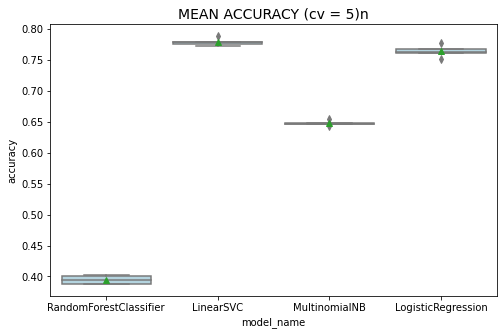

In [27]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)n", size=14);

<a id='sect5'></a>
## <font color='darkblue'>Evaluation of Text Classification Model</font>
Now, <b>let us train our model using ‘Linear Support Vector Machine’, so that we can evaluate and check it performance on unseen data</b>.

In [29]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

We will generate claasifiaction report, to get more insights on model performance.

In [30]:
# Classification report
print('ttttCLASSIFICATIION METRICSn')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

ttttCLASSIFICATIION METRICSn
                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other       0.81      0.88      0.84       783
                                   Debt collection       0.76      0.80      0.78       588
                                     Consumer Loan       0.52      0.22      0.31        73
                       Credit card or prepaid card       0.73      0.82      0.77       253
                                          Mortgage       0.87      0.92      0.90       340
                             Vehicle loan or lease       0.43      0.14      0.21        43
                                      Student loan       0.85      0.85      0.85       155
         Payday loan, title loan, or personal loan       0.50      0.17      0.26        40
                       Checking or savings account       0.61      0.60      0.61        85
                           Bank account or service

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the above classification report, we can observe that <b>the classes which have a greater number of occurrences tend to have a good f1-score compared to other classes</b>. The categories which yield better classification results are `Student loan`, `Mortgage` and `Credit reporting, repair, or other`. The classes like `Debt collection` and `credit card or prepaid card` can also give good results. <b>Now let us plot the confusion matrix to check the miss classified predictions</b>.

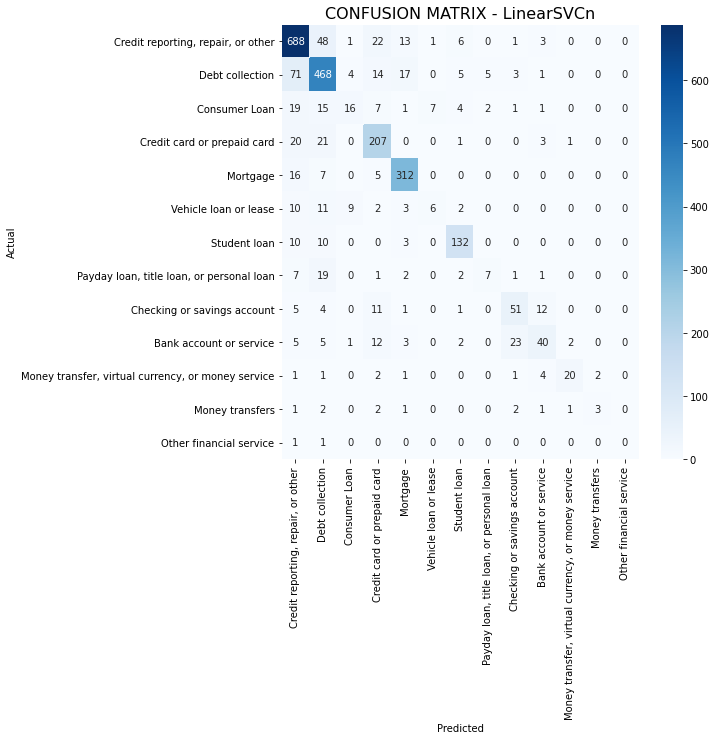

In [31]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVCn", size=16);

From the above confusion matrix, we can say that the model is doing a pretty decent job. It has classified most of the categories accurately.

<a id='sect6'></a>
## <font color='darkblue'>Prediction</font>
Let us make some prediction on the unseen data and check the model performance.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [33]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

In [34]:
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

In [35]:
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [36]:
complaint = """I have received over 27 emails from XXXX XXXX who is a representative from Midland Funding LLC. 
From XX/XX/XXXX I received approximately 6 emails. From XX/XX/XXXX I received approximately 6 emails. 
From XX/XX/XXXX I received approximately 9 emails. From XX/XX/XXXX I received approximately 6 emails. 
All emails came from the same individual, XXXX XXXX. It is becoming a nonstop issue of harassment."""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Debt collection']


In [37]:
complaint = """Respected Sir/ Madam, I am exploring the possibilities for financing my daughter 's 
XXXX education with private loan from bank. I am in the XXXX on XXXX visa. 
My daughter is on XXXX dependent visa. As a result, she is considered as international student. 
I am waiting in the Green Card ( Permanent Residency ) line for last several years.
I checked with Discover, XXXX XXXX websites. While they allow international students to apply for loan, they need cosigners who are either US citizens or Permanent Residents. I feel that this is unfair.
I had been given mortgage and car loans in the past which I closed successfully. I have good financial history. 
I think I should be allowed to remain cosigner on the student loan. I would be much obliged if you could look into it. Thanking you in advance. Best Regards"""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Student loan']


In [38]:
complaint = """They make me look like if I was behind on my Mortgage on the month of XX/XX/2018 & XX/XX/XXXX when I was not and never was, when I was even giving extra money to the Principal.
The Money Source Web site and the managers started a problem, when my wife was trying to increase the payment, so more money went to the Principal and two payments came out that month and because
I reverse one of them thru my Bank as Fraud they took revenge and committed slander against me by reporting me late at the Credit Bureaus, for 45 and 60 days, when it was not thru. Told them to correct that and the accounting department or the company revert that letter from going to the Credit Bureaus to correct their injustice. The manager by the name XXXX requested this for the second time and nothing yet. I am a Senior of XXXX years old and a Retired XXXX Veteran and is a disgraced that Americans treat us that way and do not want to admit their injustice and lies to the Credit Bureau."""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Mortgage']


The model is not perfect, yet it is performing very good.